# KMeans Clustering from Scratch
***
## Table of Contents
1. Load Data
***

K_Means is an unsupervised algorithm that partitions the data into $K$ clusters, minimising the within-cluster variance.

1. Initialisation: Randomly choose $K$ points as initial cluster centroids.
2. Assignment: Assign each point to the closest centroid.
3. Update: Recalculate centroids as the mean of all points in each cluster.
4. Iterate: Repeat until convergence occurs (e.g., centroids stop changing significantly).

In [420]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

## 1. Load Data

In [421]:
iris = load_iris()
X = iris.data

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


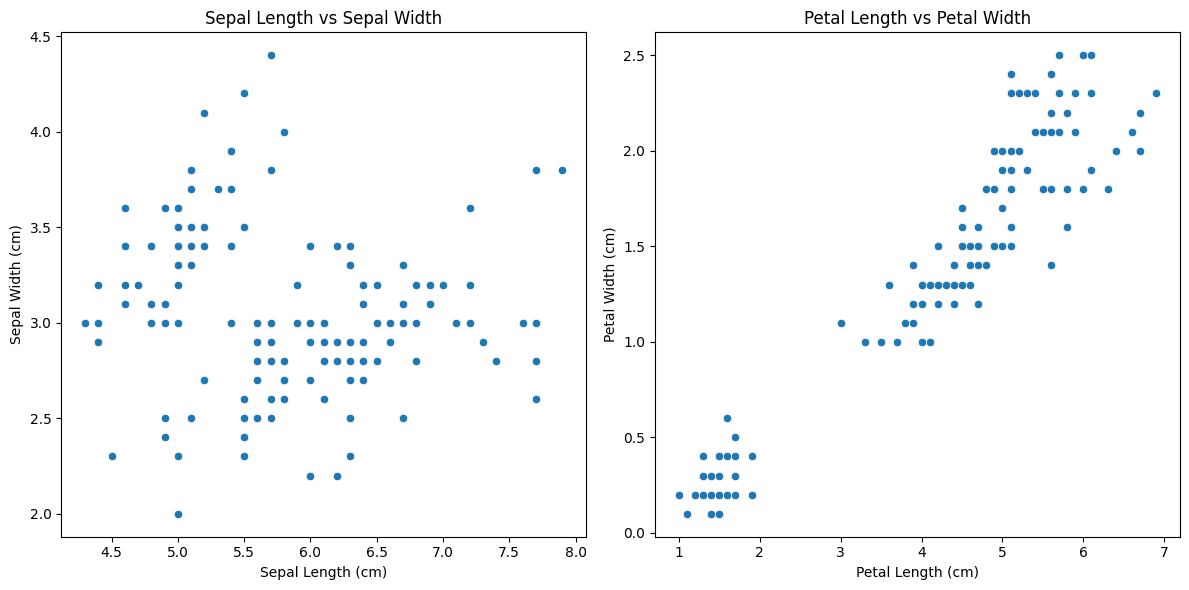

In [422]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for i, feature in enumerate(['sepal', 'petal']):
    sns.scatterplot(
        ax=axes[i], data=df, x=f'{feature} length (cm)', y=f'{feature} width (cm)')
    axes[i].set_title(
        f'{str.title(feature)} Length vs {str.title(feature)} Width')
    axes[i].set_xlabel(f'{str.title(feature)} Length (cm)')
    axes[i].set_ylabel(f'{str.title(feature)} Width (cm)')
plt.tight_layout()
plt.show()

## 2. Initialise Centroids

In [423]:
def initialise_centroids(X: np.ndarray, k: int, random_seed: int = 10) -> np.ndarray:
    """
    Randomly selects k points from X to serve as initial centroids.

    Parameters:
    - X (np.ndarray): ndarray of shape (n_samples, n_features)
    - k (int): number of clusters

    Returns:
    - centroids (np.ndarray): ndarray of shape (k, n_features)
    """
    np.random.seed(random_seed)  # For reproducibility
    random_indices = np.random.choice(len(X), size=k, replace=False)
    return X[random_indices]

## 3. Distance Metric

In [424]:
def calculate_euclidean(points: np.array, centroid: np.array) -> np.array:
    """
    Computes Euclidean distance between a batch of points and a centroid.

    Parameters:
    - points (np.array): ndarray of shape (n_samples, n_features)
    - centroid (np.array): ndarray of shape (n_features,)

    Returns:
    - distances (np.array): calculated euclidean distance from all points to centroids (n_samples,)
    """
    return np.sqrt(np.sum((points - centroid) ** 2, axis=1))

## 4. Assign Points

In [425]:
def assign_clusters(X: np.ndarray, centroids: np.ndarray):
    """
    Assigns each point in X to the closest centroid.

    Parameters:
    - X (np.ndarray): ndarray of shape (n_samples, n_features)
    - centroids (np.ndarray): ndarray of shape (k, n_features)

    Returns:
    - clusters (np.ndarray): ndarray of shape (n_samples,) with cluster labels (0 to k-1)
    """
    distances = np.array([calculate_euclidean(X, centroid)
                         for centroid in centroids])
    return np.argmin(distances, axis=0)

## 5. Update Centroids

In [426]:
def update_centroids(X: np.ndarray, clusters: np.ndarray, k: int) -> np.ndarray:
    """
    Computes the new centroids as the mean of the points assigned to each cluster.

    Parameters:
    - X (np.ndarray): ndarray of shape (n_samples, n_features)
    - clusters (np.ndarray): ndarray of shape (n_samples,) with cluster labels
    - k (int): number of clusters

    Returns:
    - new_centroids (np.ndarray): ndarray of shape (k, n_features)
    """
    return np.array([X[clusters == i].mean(axis=0) for i in range(k)])

## 6. Check Convergence

In [427]:
def is_converged(old_centroids: np.ndarray, new_centroids: np.ndarray, tol: float = 1e-4) -> bool:
    """
    Checks if centroids have stopped changing significantly.

    Parameters:
    - old_centroids (np.ndarray): ndarray of previous centroids
    - new_centroids (np.ndarray): ndarray of updated centroids
    - tol (float): tolerance threshold for convergence

    Returns:
    - Boolean: True if ALL centroids converged
    """
    return np.all(np.linalg.norm(new_centroids - old_centroids, axis=1) < tol)

In [428]:
def kmeans_clustering(X, k, max_iters=100, tol=1e-4):
    centroids = initialise_centroids(X, k)
    history = [{'centroids': centroids.copy(), 'labels': None}]

    for i in range(max_iters):
        distances = np.array([calculate_euclidean(X, c) for c in centroids]).T
        labels = np.argmin(distances, axis=1)
        new_centroids = update_centroids(X, labels, k)

        history.append(
            {'centroids': new_centroids.copy(), 'labels': labels.copy()})

        if is_converged(centroids, new_centroids, tol):
            print(f"Converged after {i} iterations.")
            break

        centroids = new_centroids

    return labels, centroids, history

## 7. Visualisation

In [429]:
def plot_kmeans_clusters(df, features, clusters_list, centroids_list, palette):
    """
    Plot KMeans clustered data with centroids for given features.

    Parameters:
    - df: pandas DataFrame containing the data
    - features: list of strings, e.g. ['sepal', 'petal']
    - clusters_list: list of cluster arrays corresponding to each feature set
    - centroids_list: list of numpy arrays of centroids corresponding to each feature set
    - palette: seaborn colour palette (list of colours)
    """
    colors = palette.as_hex()
    fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 6))

    # Handle single subplot case
    if len(features) == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        clusters = clusters_list[i]
        centroids = centroids_list[i]

        # Get the appropriate columns for this feature set
        if i == 0:  # First plot (sepal)
            x_col, y_col = df.columns[0], df.columns[1]
        else:  # Second plot (petal)
            x_col, y_col = df.columns[2], df.columns[3]

        # Create scatter plot with cluster colours
        for cluster_id in range(len(centroids)):
            mask = clusters == cluster_id
            axes[i].scatter(df.loc[mask, x_col], df.loc[mask, y_col],
                            c=[colors[cluster_id]], s=60, alpha=0.7,
                            label=f'Cluster {cluster_id}')

        # Plot centroids
        for j, (x, y) in enumerate(centroids):
            axes[i].scatter(x, y, color=colors[j], marker='*', s=150,
                            edgecolor='black', linewidth=1.5,
                            label=f'Centroid {j}')

        axes[i].set_title(f'{feature.title()} Length vs Width (Clustered)')
        axes[i].set_xlabel(f'{feature.title()} Length (cm)')
        axes[i].set_ylabel(f'{feature.title()} Width (cm)')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [436]:
def plot_kmeans_transitions(X, history, title, palette, steps):
    colors = palette.as_hex()
    total_iters = len(history)
    indices = np.linspace(0, total_iters - 1, steps, dtype=int)

    fig, axes = plt.subplots(1, steps, figsize=(4 * steps, 5))

    for ax, idx in zip(axes, indices):
        data = history[idx]
        centroids = data['centroids']
        labels = data['labels']

        if labels is None:
            ax.scatter(X[:, 0], X[:, 1], color='gray', s=40, alpha=0.6)
        else:
            for j, color in enumerate(colors):
                points = X[labels == j]
                ax.scatter(points[:, 0], points[:, 1], color=color,
                           s=40, alpha=0.8, label=f'Cluster {j}')

        for j, (x, y) in enumerate(centroids):
            ax.scatter(x, y, color=colors[j], marker='*', s=150,
                       edgecolor='black', linewidth=1.5, label=f'Centroid {j}')

        ax.set_title(f'Iteration {idx}')
        ax.set_xlabel("Length (cm)")
        ax.set_ylabel("Width (cm)")
        ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
        ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Converged after 7 iterations.
Converged after 3 iterations.


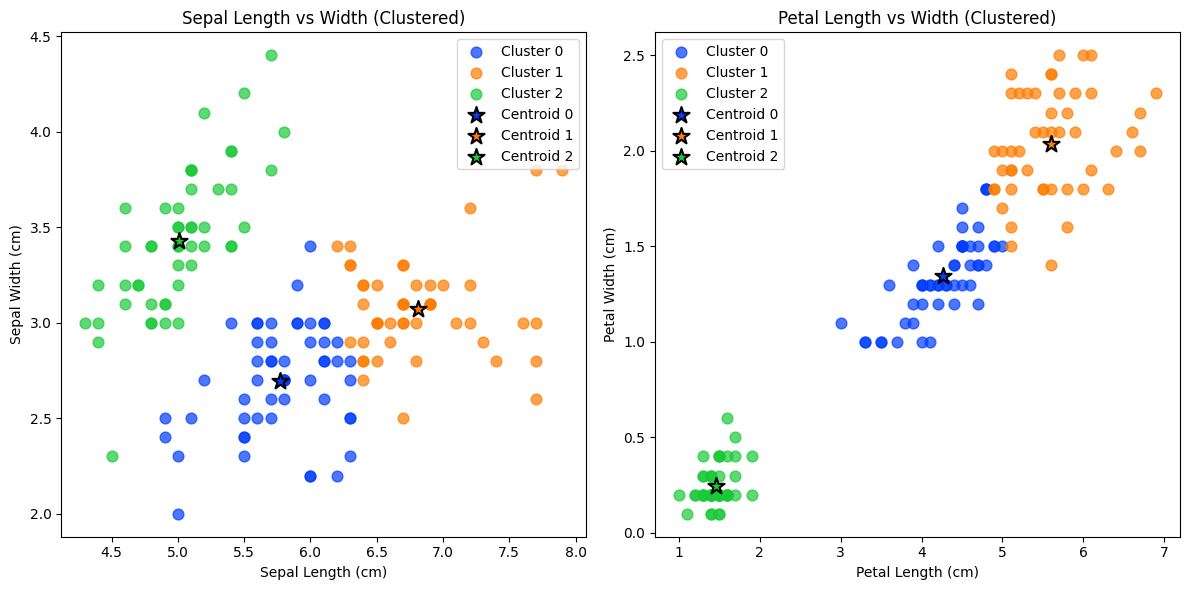

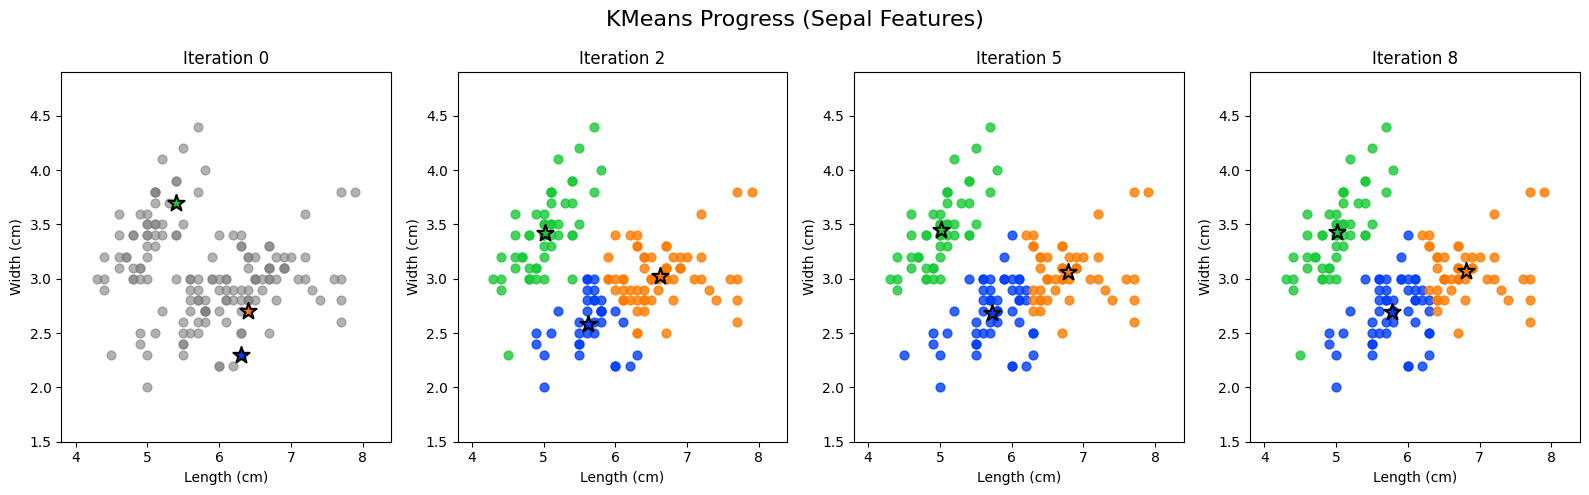

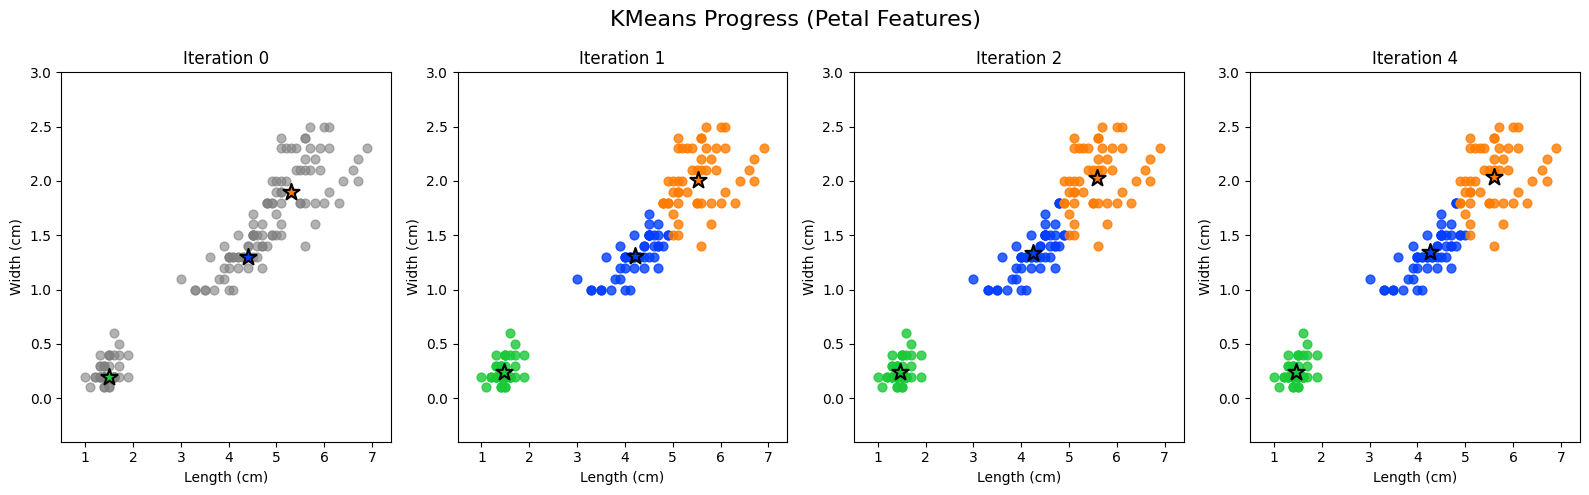

In [437]:
k = 3
X_sepal = df.iloc[:, :2].values
clusters_sepal, centroids_sepal, sepal_history = kmeans_clustering(X_sepal, k)

# Petal features
X_petal = df.iloc[:, 2:4].values
clusters_petal, centroids_petal, petal_history = kmeans_clustering(X_petal, k)

palette = sns.color_palette('bright', n_colors=k)
features = ['sepal', 'petal']
clusters_list = [clusters_sepal, clusters_petal]
centroids_list = [centroids_sepal, centroids_petal]

# Call the updated plotting function
plot_kmeans_clusters(df, features, clusters_list, centroids_list, palette)

# Plot transitions for sepal
plot_kmeans_transitions(
    X_sepal, sepal_history, "KMeans Progress (Sepal Features)", palette, steps=4)

# Plot transitions for petal
plot_kmeans_transitions(
    X_petal, petal_history, "KMeans Progress (Petal Features)", palette, steps=4)